Load Data file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/My Drive/Colab Notebooks'
os.chdir(project_path)

In [3]:
import pandas as pd

In [4]:
it_df = pd.read_excel("input_data.xlsx")

In [5]:
it_df.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [6]:
callers = it_df['Caller'].unique() 
it_df.drop("Caller", axis=1, inplace=True)
it_df.head()

,Short description,Description,Assignment group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


In [7]:
it_df.shape

(8500, 3)

In [8]:
# check for Null and drop null rows
it_df.isnull().sum()
it_df.dropna(inplace=True)

In [9]:
it_df.shape

(8491, 3)

In [10]:
# check and drop duplicate rows
it_df[it_df.duplicated(['Short description','Description'])]
it_df.drop_duplicates(['Short description','Description'],inplace=True)
it_df.shape

(7887, 3)

In [11]:
it_df['Assignment group'].value_counts()

GRP_0     3421
GRP_8      644
GRP_24     285
GRP_12     255
GRP_9      251
          ... 
GRP_70       1
GRP_73       1
GRP_35       1
GRP_67       1
GRP_72       1
Name: Assignment group, Length: 74, dtype: int64

Groups: 74


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


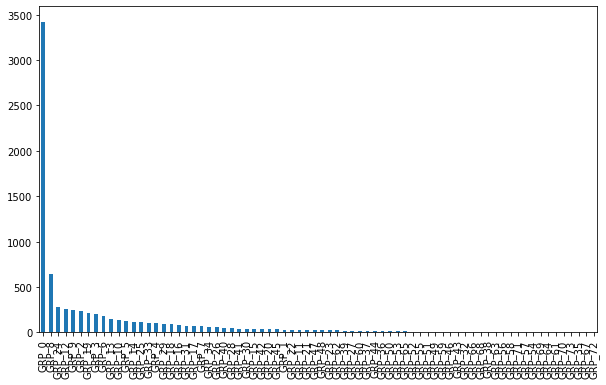

In [12]:
# plot pareto chart
import matplotlib.pyplot as plt
import seaborn as sns

# Identify unique groups
print("Groups: " + str(it_df["Assignment group"].nunique()))

# Plot the groups
fig = plt.figure(figsize=(10,6))
pd.value_counts(it_df["Assignment group"]).plot(kind="bar")

Solution 1 : Drop records, for which we have limied set of samples for a specific group

In [13]:
threshold=100
it_df_sol1 = it_df.groupby('Assignment group').filter(lambda x : len(x)>threshold)

In [14]:
it_df_sol1.shape

(6444, 3)

In [15]:
print("Groups: " + str(it_df_sol1["Assignment group"].nunique()))

Groups: 15


Conclusion : Out of 74 groups, we only left with 15 groups. Also 50% of the data belongs to group_0. This might not be a good model as lot of groups will be not included i n the model, so dropping this EDA approach.

Solution 2 : Merge the data, group all the tickets under one "Group A", if the frequency count is less then threshold

In [16]:
temp_it_df = pd.DataFrame(it_df['Assignment group'].value_counts())
temp_it_df = temp_it_df.T
temp_it_df

,GRP_0,GRP_8,GRP_24,GRP_12,GRP_9,GRP_2,GRP_19,GRP_3,GRP_6,GRP_13,GRP_10,GRP_5,GRP_14,GRP_25,GRP_33,GRP_4,GRP_29,GRP_18,GRP_16,GRP_31,GRP_17,GRP_7,GRP_34,GRP_26,GRP_40,GRP_28,GRP_41,GRP_30,GRP_15,GRP_42,GRP_20,GRP_45,GRP_1,GRP_22,GRP_11,GRP_21,GRP_47,GRP_48,GRP_23,GRP_62,GRP_39,GRP_27,GRP_60,GRP_37,GRP_44,GRP_36,GRP_50,GRP_53,GRP_65,GRP_52,GRP_55,GRP_51,GRP_49,GRP_59,GRP_46,GRP_43,GRP_32,GRP_66,GRP_68,GRP_38,GRP_63,GRP_56,GRP_58,GRP_71,GRP_57,GRP_54,GRP_69,GRP_64,GRP_61,GRP_70,GRP_73,GRP_35,GRP_67,GRP_72
Assignment group,3421,644,285,255,251,241,213,198,182,145,140,128,118,116,107,99,97,88,85,69,68,68,60,56,45,44,40,39,38,37,36,35,31,31,30,28,27,25,24,24,19,18,16,16,15,14,13,11,11,9,8,8,6,6,6,5,4,4,3,3,3,3,3,2,2,2,2,1,1,1,1,1,1,1


In [17]:
it_df_sol2 = it_df
it_df_sol2['Count'] = it_df_sol2.apply(lambda row: temp_it_df[row['Assignment group']] , axis=1)

it_df_sol2.loc[it_df_sol2['Count'] <= threshold , "Assignment group"] = "GRP_A"

In [18]:
it_df_sol2['Assignment group'].value_counts()

GRP_0     3421
GRP_A     1443
GRP_8      644
GRP_24     285
GRP_12     255
GRP_9      251
GRP_2      241
GRP_19     213
GRP_3      198
GRP_6      182
GRP_13     145
GRP_10     140
GRP_5      128
GRP_14     118
GRP_25     116
GRP_33     107
Name: Assignment group, dtype: int64

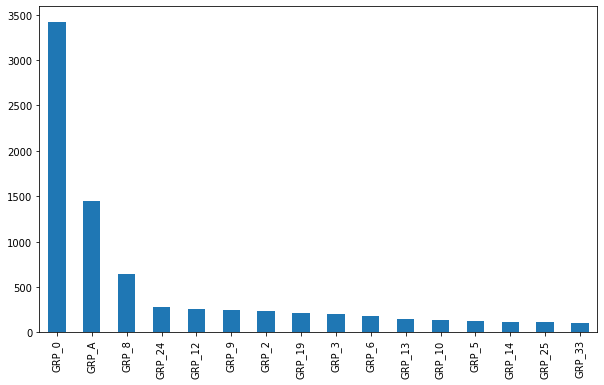

In [19]:
# Plot the groups
fig = plt.figure(figsize=(10,6))
pd.value_counts(it_df_sol2["Assignment group"]).plot(kind="bar")

In [20]:
it_df_sol2.drop(columns='Count',inplace=True)
it_df_sol2.head()

,Short description,Description,Assignment group
0,login issue,-verified user details.(employee# & manager na...,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,GRP_0
4,skype error,skype error,GRP_0


Prepare the columns by merging both Short Description and Description

In [21]:
#it_df_sol2['Full Description'] = it_df_sol2['Short description'] + ' '+ it_df_sol2['Description']
it_df_sol2.drop(columns=['Short description'],inplace=True)
it_df_sol2.head()

,Description,Assignment group
0,-verified user details.(employee# & manager na...,GRP_0
1,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,GRP_0
2,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,GRP_0
3,unable to access hr_tool page,GRP_0
4,skype error,GRP_0


Now, need to cleanup the data, so that we can do text classification. So for this cetain actions needed :
1. Convert the entire text in lower case
2. Remove HTML tags
3. Remove stopwords
4. Remove punctuations, special characters, numbers

In [22]:
# Define a function to clean the data
import re
from dateutil import parser
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False
        
def clean_data(text):
    text = text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in callers:
      namelist = [part for part in name.split()]
      for namepart in namelist: 
          text = text.replace(namepart,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text

In [23]:
it_df_sol2['Description'] = it_df_sol2['Description'].apply(clean_data)

In [24]:
it_df_sol2.head()

,Description,Assignment group
0,verified user details employee and manager nam...,GRP_0
1,hello team my meetings skype meetings etc are ...,GRP_0
2,hi cannot log on to vpn best,GRP_0
3,unable to access hr tool page,GRP_0
4,skype error,GRP_0


Lemmatisation and stop words removal

In [25]:
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

stop = stopwords.words('english')
for i,text in enumerate(it_df_sol2['Description']):
  it_df_sol2['Description'][i]=" ".join(word for word in text.split(' ') if word not in stop)

import spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

it_df_sol2['Description'] = it_df_sol2['Description'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [26]:
it_df_sol2.head()

,Description,Assignment group
0,verify user detail employee manager name check...,GRP_0
1,hello team meeting skype meeting etc appear ou...,GRP_0
2,hi can not log vpn best,GRP_0
3,unable access hr tool page,GRP_0
4,skype error,GRP_0


In [27]:
combined_text=it_df_sol2.Description.values.tolist()

In [43]:
combined_text[1]

'hello team meeting skype meeting etc appear outlook calendar somebody please advise correct kind'

In [32]:
# Tokenize
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(combined_text))

In [44]:
data_words[1]

['hello',
 'team',
 'meeting',
 'skype',
 'meeting',
 'etc',
 'appear',
 'outlook',
 'calendar',
 'somebody',
 'please',
 'advise',
 'correct',
 'kind']

In [40]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [45]:
bigram_mod[data_words[1]]

['hello',
 'team',
 'meeting',
 'skype',
 'meeting',
 'etc',
 'appear',
 'outlook',
 'calendar',
 'somebody',
 'please',
 'advise',
 'correct',
 'kind']

In [47]:
trigram_mod[data_words[1]]

['hello',
 'team',
 'meeting',
 'skype',
 'meeting',
 'etc',
 'appear',
 'outlook',
 'calendar',
 'somebody',
 'please',
 'advise',
 'correct',
 'kind']

In [48]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [49]:
data_words_bigrams = make_bigrams(data_words)

In [52]:
it_df_sol2_new = it_df_sol2.copy()
it_df_sol2_new['words'] = data_words_bigrams
it_df_sol2_new.head()

,Description,Assignment group,words
0,verify user detail employee manager name check...,GRP_0,"[verify, user, detail, employee, manager, name..."
1,hello team meeting skype meeting etc appear ou...,GRP_0,"[hello, team, meeting, skype, meeting, etc, ap..."
2,hi can not log vpn best,GRP_0,"[hi, can_not, log, vpn, best]"
3,unable access hr tool page,GRP_0,"[unable, access, hr, tool, page]"
4,skype error,GRP_0,"[skype, error]"


In [53]:
value = it_df_sol2_new['Assignment group'].value_counts().sort_values(ascending=False).index
value

Index(['GRP_0', 'GRP_A', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2',
       'GRP_19', 'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14',
       'GRP_25', 'GRP_33'],
      dtype='object')

In [67]:
from wordcloud import WordCloud
# Creating a function for wordcloud
def wordcloud_grp(f, x):
    wordclouds_0=' '.join(map(str, f))

    wc = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, max_words=100).generate(wordclouds_0)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common 100 words of {}".format(x))
    plt.margins(x=0, y=0)
    plt.show()

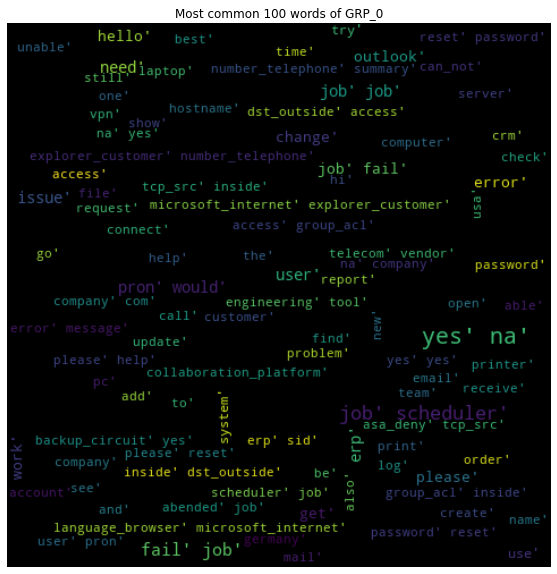

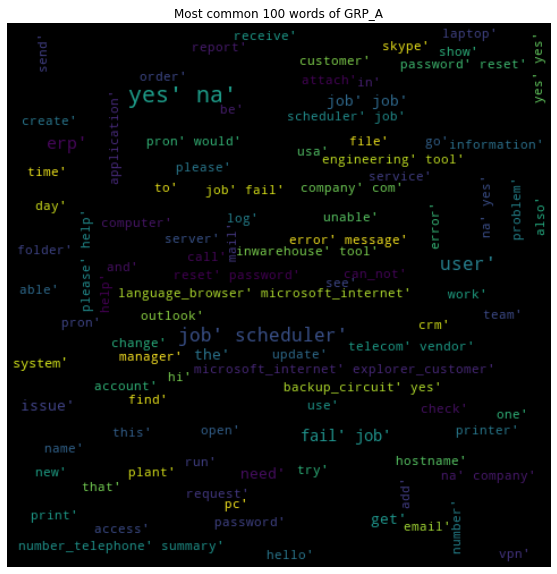

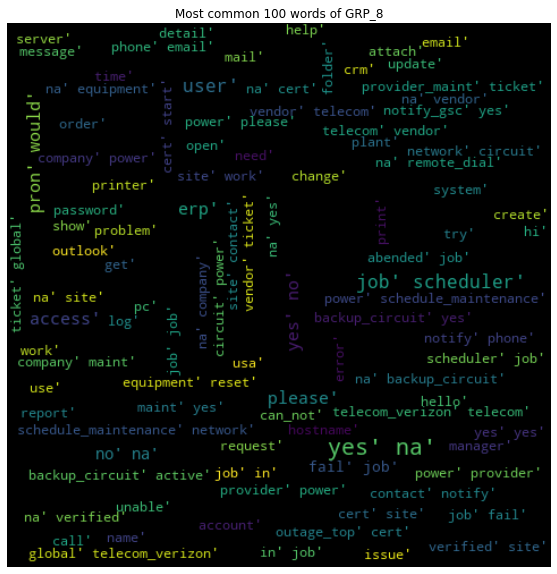

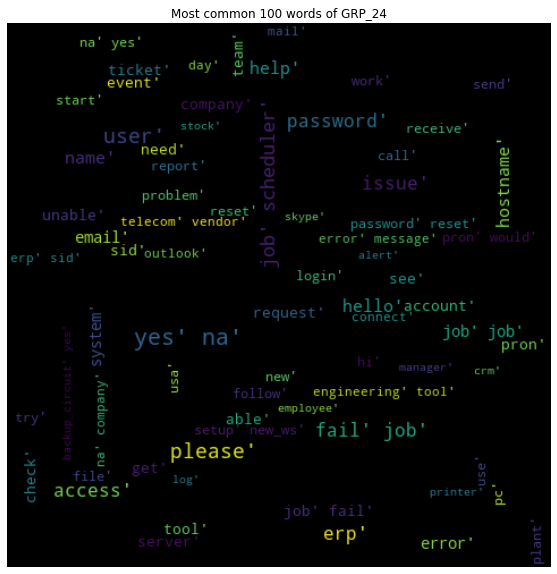

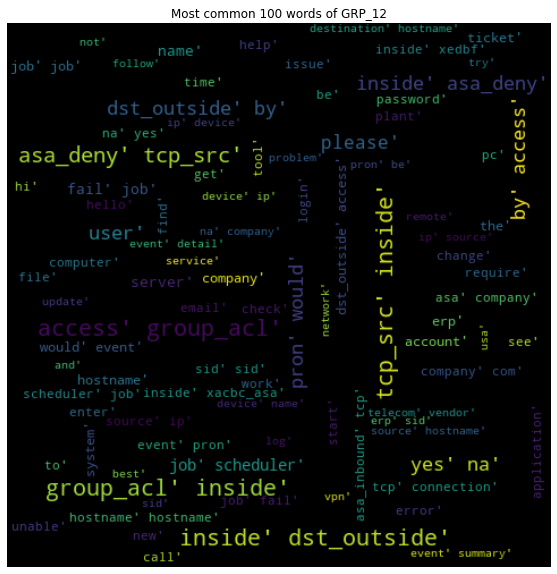

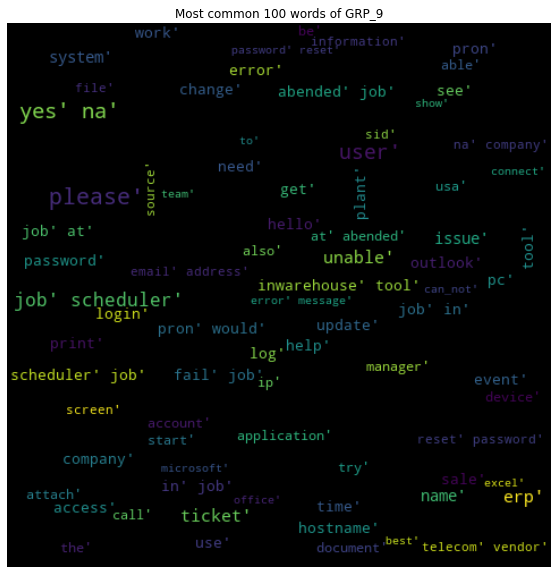

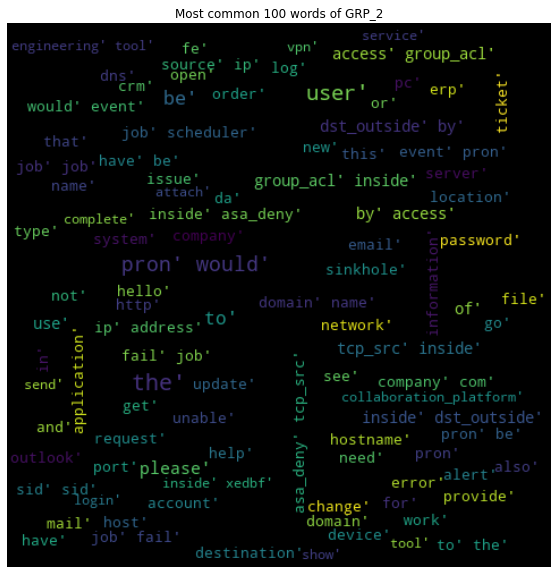

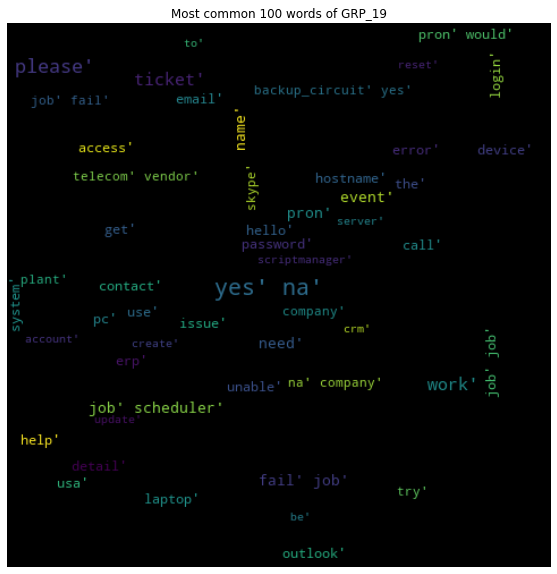

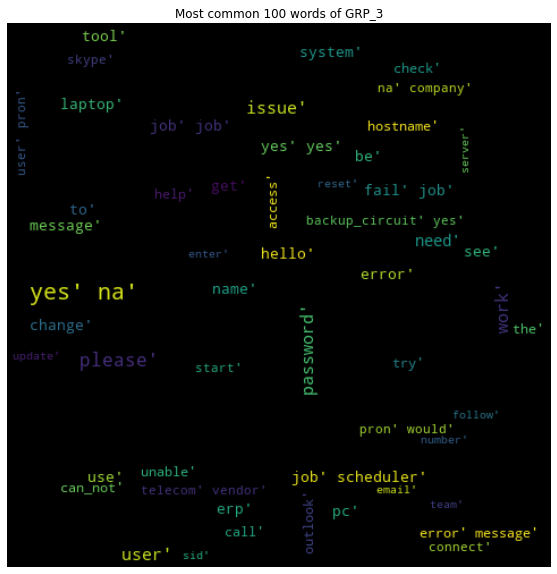

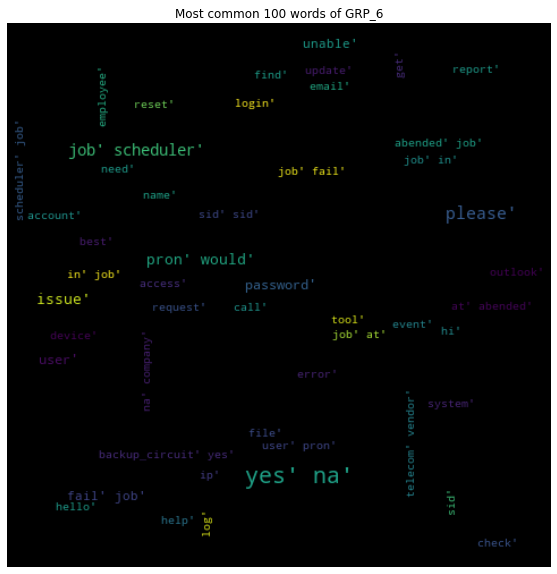

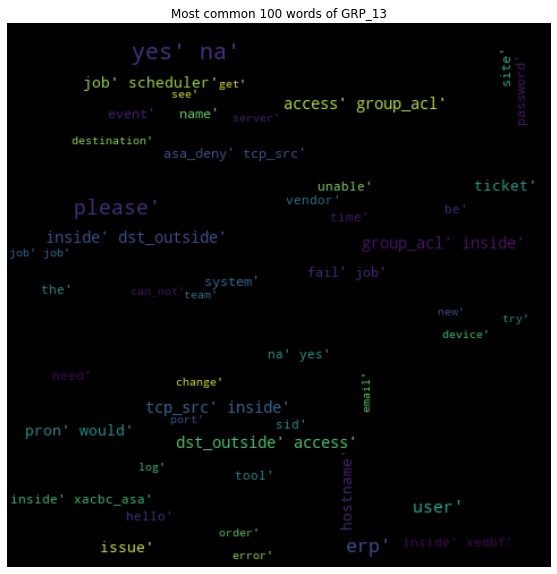

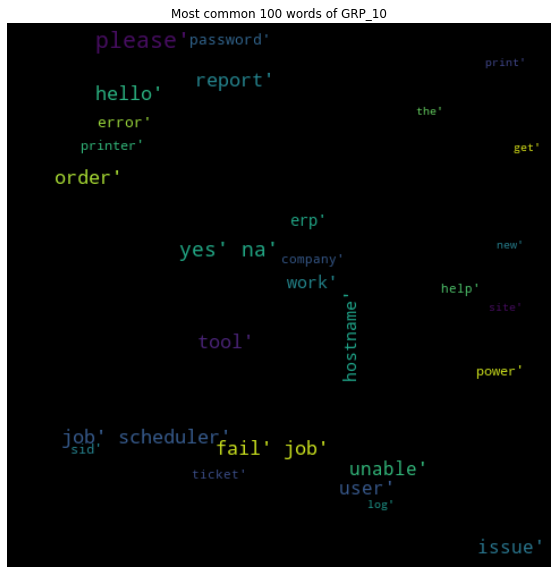

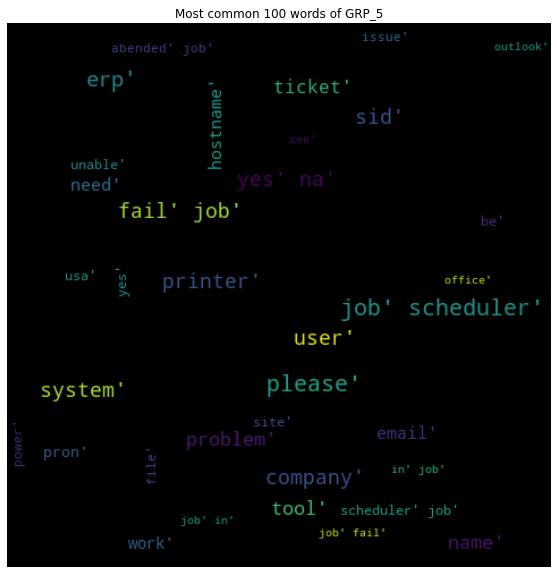

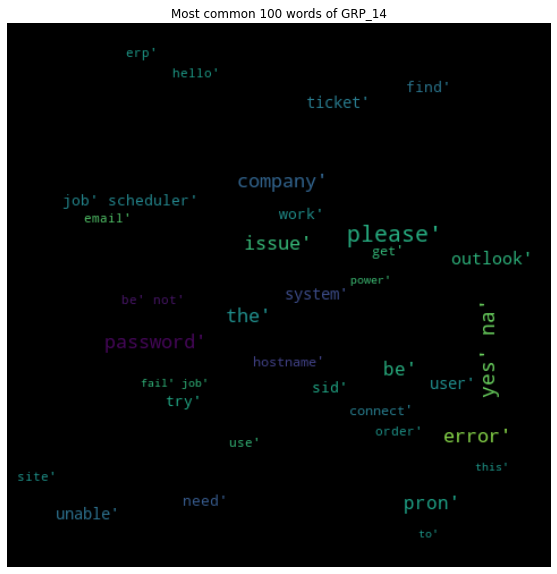

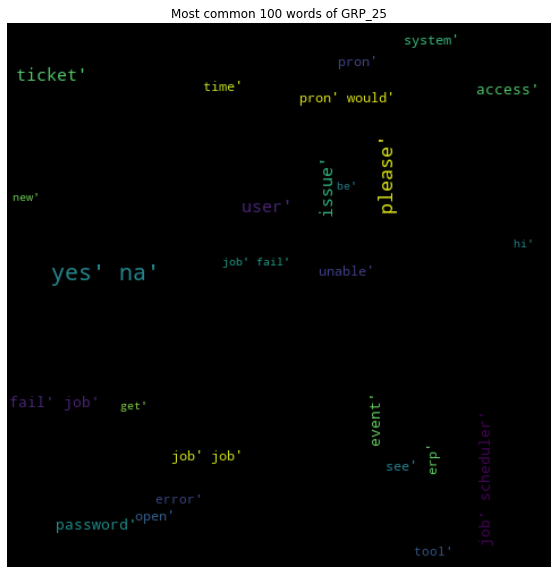

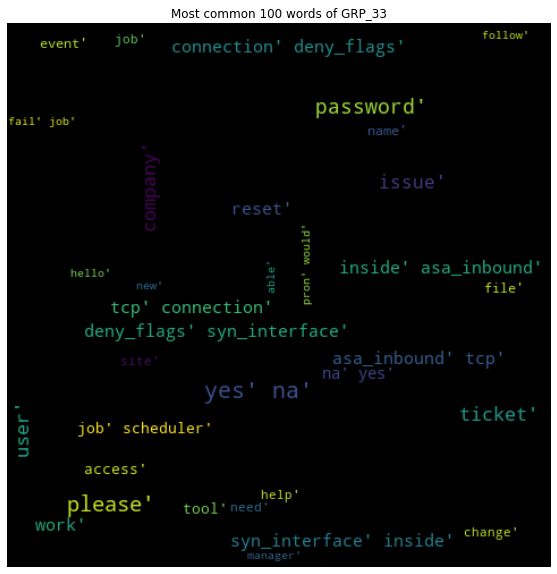

In [68]:
for i in range(16):
    Grp = it_df_sol2_new[it_df_sol2_new ['Assignment group'] == value[i]]
    Grp = Grp['words']
    wordcloud_grp(Grp,value[i])